In [2]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
# Load the data into a Pandas dataframe
df = pd.read_csv('/content/main_data.csv')

In [5]:
df

,Unnamed: 0,content,label
0,0,Researchers use deep learning to simulate chlo...,Positive
1,1,Why is our @Conservatives government so evil?\...,Negative
2,2,"Texas Oilfield Waste Company Contributed $53,7...",Negative
3,3,Epic California snowpack is now the deepest it...,Negative
4,4,If #climatechange is real and not a hoax why d...,Negative
...,...,...,...
4405,353,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral
4406,354,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral
4407,355,['Motivation direction on how to discover # su...,Positive
4408,356,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral


In [6]:
df['label'].value_counts()

Neutral     1842
Positive    1822
Negative     746
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

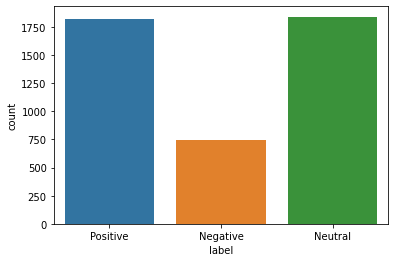

In [7]:
# Create a countplot of the labels
sns.countplot(x='label', data=df)

### **PRE-PROCESSING**

In [8]:
# download stopwords and wordnet lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [9]:
def preprocess(text):
    # remove special characters and digits
    text = re.sub('[^a-zA-Z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # split into words
    words = text.split()
    # remove stopwords
    stopword_list = set(stopwords.words('english'))
    words = [w for w in words if w not in stopword_list]
    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    # join the words back into a string
    text = ' '.join(words)
    return text

In [10]:
# apply preprocessing function to the content column
df['content'] = df['content'].apply(preprocess)

In [11]:
df

,Unnamed: 0,content,label
0,0,research use deep learn simul chlorophyl amp p...,Positive
1,1,conserv govern evil rishisunak climatechang co...,Negative
2,2,texa oilfield wast compani contribut regul ove...,Negative
3,3,epic california snowpack deepest decad thank c...,Negative
4,4,climatechang real hoax biden obama gore ocean ...,Negative
...,...,...,...
4405,353,team bit bit com diversityequityinclus dei soc...,Neutral
4406,354,team bit bit com diversityequityinclus dei soc...,Neutral
4407,355,motiv direct discov sustain initi leader organ...,Positive
4408,356,team bit bit com diversityequityinclus dei soc...,Neutral


### OVERSAMPLING

In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
# define the oversampler
oversampler = RandomOverSampler(sampling_strategy={'Negative': 1842, 'Positive': 1822, 'Neutral': 1842})

In [14]:
# separate the features and the label
X = df.drop('label', axis=1)
y = df['label']

In [15]:
# oversample the negative class
X_resampled, y_resampled = oversampler.fit_resample(X, y)


In [16]:
# create the updated dataframe
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [17]:
df_resampled

,Unnamed: 0,content,label
0,0,research use deep learn simul chlorophyl amp p...,Positive
1,1,conserv govern evil rishisunak climatechang co...,Negative
2,2,texa oilfield wast compani contribut regul ove...,Negative
3,3,epic california snowpack deepest decad thank c...,Negative
4,4,climatechang real hoax biden obama gore ocean ...,Negative
...,...,...,...
5501,1194,horrifi scientif report motiv mani energi prof...,Negative
5502,225,new climat news low impact human recreat chang...,Negative
5503,163,consequ russia invas ukrain amp worsen impact ...,Negative
5504,942,drought weari west longer turn blind eye towar...,Negative


In [18]:
df_resampled['label'].value_counts()

Negative    1842
Neutral     1842
Positive    1822
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

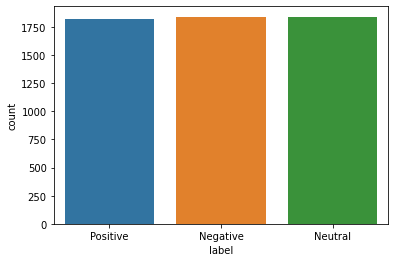

In [19]:
# Create a countplot of the labels
sns.countplot(x='label', data=df_resampled)

In [20]:
X=df_resampled['content']

In [21]:
X

0       research use deep learn simul chlorophyl amp p...
1       conserv govern evil rishisunak climatechang co...
2       texa oilfield wast compani contribut regul ove...
3       epic california snowpack deepest decad thank c...
4       climatechang real hoax biden obama gore ocean ...
                              ...                        
5501    horrifi scientif report motiv mani energi prof...
5502    new climat news low impact human recreat chang...
5503    consequ russia invas ukrain amp worsen impact ...
5504    drought weari west longer turn blind eye towar...
5505    spotlight climat chang law regul polici thaila...
Name: content, Length: 5506, dtype: object

In [22]:
y=df_resampled['label']

In [23]:
y

0       Positive
1       Negative
2       Negative
3       Negative
4       Negative
          ...   
5501    Negative
5502    Negative
5503    Negative
5504    Negative
5505    Negative
Name: label, Length: 5506, dtype: object

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [25]:
# Convert the text data to numerical vectors using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### TFIDF - NaiveBayes

In [38]:
# Train a Naive Bayes classifier on the training data
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [39]:
# Make predictions on the testing data and compute evaluation metrics
y_pred = clf.predict(X_test_tfidf)

In [40]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.75      0.95      0.84       389
     Neutral       0.87      0.62      0.72       370
    Positive       0.76      0.77      0.76       343

    accuracy                           0.78      1102
   macro avg       0.79      0.78      0.78      1102
weighted avg       0.79      0.78      0.78      1102



### TFIDF - Logistic Regression

In [46]:
logreg = LogisticRegression(C = 1000.0, 
                            penalty = 'l2', 
                            solver = 'liblinear')
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(C=1000.0, solver='liblinear')

In [47]:
y_pred = logreg.predict(X_test_tfidf)

In [48]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.92      0.96      0.94       389
     Neutral       0.90      0.84      0.87       370
    Positive       0.88      0.89      0.88       343

    accuracy                           0.90      1102
   macro avg       0.90      0.90      0.90      1102
weighted avg       0.90      0.90      0.90      1102



### **TFIDF - Logistic Regression**

In [49]:
# Train a random forest classifier on the training data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [52]:
# Make predictions on the testing data and compute evaluation metrics
y_pred = rfc.predict(X_test_tfidf)

In [53]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.90      0.95      0.92       389
     Neutral       0.86      0.81      0.83       370
    Positive       0.83      0.84      0.83       343

    accuracy                           0.87      1102
   macro avg       0.86      0.86      0.86      1102
weighted avg       0.86      0.87      0.86      1102



### TFIDF - DECISION TREE

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Decision Tree Classifier object
dtc = DecisionTreeClassifier(random_state=42)

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.7213902074089361


In [56]:
# Initialize a decision tree model with default parameters
dt_model = DecisionTreeClassifier(max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2)


# Fit the model on the training data
dt_model.fit(X_train_tfidf, y_train)

# Predict the target variable on the testing data
y_pred = dt_model.predict(X_test_tfidf)

# Calculate the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.7450090744101633


In [57]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.86      0.91      0.89       389
     Neutral       0.67      0.66      0.67       370
    Positive       0.68      0.64      0.66       343

    accuracy                           0.75      1102
   macro avg       0.74      0.74      0.74      1102
weighted avg       0.74      0.75      0.74      1102



### TFIDF - SVM

In [58]:
# Create SVM classifier object
classifier = SVC(kernel='linear')

# Train SVM classifier
classifier.fit(X_train_tfidf, y_train)

# Predict target values for testing set
y_pred = classifier.predict(X_test_tfidf)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.8330308529945554


In [59]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.88      0.94      0.91       389
     Neutral       0.83      0.72      0.78       370
    Positive       0.77      0.83      0.80       343

    accuracy                           0.83      1102
   macro avg       0.83      0.83      0.83      1102
weighted avg       0.83      0.83      0.83      1102



### WORD2VEC

In [60]:
w2v_model = Word2Vec(X, size=100, window=5, min_count=1, workers=4)
# Vectorize the data using Word2Vec
X_train_w2v = np.array([np.mean([w2v_model.wv[word] for word in document], axis=0) for document in X_train])
X_test_w2v = np.array([np.mean([w2v_model.wv[word] for word in document], axis=0) for document in X_test])

### WORD2VEC - RANDOM FOREST

In [61]:
# Train a random forest classifier on the training data
rclf = RandomForestClassifier()
rclf.fit(X_train_w2v, y_train)

RandomForestClassifier()

In [62]:
# Make predictions on the testing data and compute evaluation metrics
y_pred = rclf.predict(X_test_w2v)

In [63]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.90      0.89      0.90       389
     Neutral       0.65      0.61      0.63       370
    Positive       0.63      0.67      0.65       343

    accuracy                           0.73      1102
   macro avg       0.73      0.73      0.73      1102
weighted avg       0.73      0.73      0.73      1102



### WORD2VEC - LOGISTIC REGRESSION

In [64]:
# Initialize a logistic regression model with default parameters
lr_model = LogisticRegression(C=0.1, solver = 'lbfgs')

# Fit the model on the training data
lr_model.fit(X_train_w2v, y_train)

# Predict the target variable on the testing data
y_pred = lr_model.predict(X_test_w2v)

# Calculate the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.39836660617059894


In [65]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.43      0.52      0.47       389
     Neutral       0.38      0.12      0.19       370
    Positive       0.37      0.55      0.44       343

    accuracy                           0.40      1102
   macro avg       0.39      0.40      0.37      1102
weighted avg       0.39      0.40      0.37      1102



WORD2VEC - DECISION TREE

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Decision Tree Classifier object
dtc = DecisionTreeClassifier(random_state=42)

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_w2v, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best hyperparameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.5842418223093592


In [67]:
# Initialize a decision tree model with default parameters
dt_model = DecisionTreeClassifier(max_depth= None, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2)

# Fit the model on the training data
dt_model.fit(X_train_w2v, y_train)

# Predict the target variable on the testing data
y_pred = dt_model.predict(X_test_w2v)

# Calculate the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.6134301270417423


In [68]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.72      0.87      0.79       389
     Neutral       0.54      0.45      0.49       370
    Positive       0.53      0.50      0.51       343

    accuracy                           0.61      1102
   macro avg       0.60      0.61      0.60      1102
weighted avg       0.60      0.61      0.60      1102



### WORD2VEC - SVM

In [69]:
# Create SVM classifier object
classifier = SVC(kernel='linear')

# Train SVM classifier
classifier.fit(X_train_w2v, y_train)

# Predict target values for testing set
y_pred = classifier.predict(X_test_w2v)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.4029038112522686


In [71]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       389
     Neutral       0.00      0.00      0.00       370
    Positive       0.31      1.00      0.47       343

    accuracy                           0.31      1102
   macro avg       0.10      0.33      0.16      1102
weighted avg       0.10      0.31      0.15      1102



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### COUNTVECTORIZER

In [72]:
# Convert the text data to numerical vectors using count Vectorizer
vectorizer = CountVectorizer()

X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

COUNTVECTORIZER - LOGISTIC REGRESSION

In [73]:
# Initialize a logistic regression model with default parameters
lr_model = LogisticRegression(C=0.1, solver = 'lbfgs')

# Fit the model on the training data
lr_model.fit(X_train_cv, y_train)

# Predict the target variable on the testing data
y_pred = lr_model.predict(X_test_cv)

# Calculate the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.779491833030853


### COUNTVECTORIZER - RANDOM FOREST

In [74]:
# Train a random forest classifier on the training data
clf = RandomForestClassifier()
clf.fit(X_train_cv, y_train)

# Make predictions on the testing data and compute evaluation metrics
y_pred = clf.predict(X_test_cv)

from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)



              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95       389
     Neutral       0.87      0.86      0.87       370
    Positive       0.87      0.87      0.87       343

    accuracy                           0.90      1102
   macro avg       0.89      0.90      0.89      1102
weighted avg       0.90      0.90      0.90      1102



### **COUNTVECTORIZER - SVM**

In [75]:
# Create SVM classifier object
classifier = SVC(C= 10, gamma= 10, kernel= 'linear')

# Train SVM classifier
classifier.fit(X_train_cv, y_train)

# Predict target values for testing set
y_pred = classifier.predict(X_test_cv)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.8720508166969148


In [78]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.84      0.93      0.88       389
     Neutral       0.71      0.66      0.69       370
    Positive       0.70      0.68      0.69       343

    accuracy                           0.76      1102
   macro avg       0.75      0.75      0.75      1102
weighted avg       0.75      0.76      0.76      1102



### COUNTVECTORIZER - DECISION TREE

In [76]:
# Initialize a decision tree model with default parameters
dt_model = DecisionTreeClassifier(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2)


# Fit the model on the training data
dt_model.fit(X_train_cv, y_train)

# Predict the target variable on the testing data
y_pred = dt_model.predict(X_test_cv)

# Calculate the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print('Accuracy:', accuracy)

Accuracy: 0.7586206896551724


/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [77]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.84      0.93      0.88       389
     Neutral       0.71      0.66      0.69       370
    Positive       0.70      0.68      0.69       343

    accuracy                           0.76      1102
   macro avg       0.75      0.75      0.75      1102
weighted avg       0.75      0.76      0.76      1102



### COUNTVECTORIZER - NAIVE BAYES

In [79]:
# Train a Naive Bayes classifier on the training data
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

# Make predictions on the testing data and compute evaluation metrics
y_pred = clf.predict(X_test_cv)

In [80]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.77      0.95      0.85       389
     Neutral       0.87      0.67      0.76       370
    Positive       0.78      0.78      0.78       343

    accuracy                           0.80      1102
   macro avg       0.81      0.80      0.80      1102
weighted avg       0.81      0.80      0.80      1102



### **GLOVE**

In [86]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [92]:
# Word-vector Size
embed_size = 300

# Unique Words
max_features = 10000

# No of words per document
max_len = 250





tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(X_train)

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(list_tokenized_train, maxlen=max_len)

list_tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(list_tokenized_test, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print('Shape of Training Data')
print(X_train.shape, y_train.shape)
print('Shape of Testing Data')
print(X_test.shape, y_test.shape)

Shape of Training Data
(4404, 250) (4404,)
Shape of Testing Data
(1102, 250) (1102,)


In [94]:
GLOVE_FILE = '/content/drive/MyDrive/glove.6B.300d.txt'

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = 'float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(GLOVE_FILE, encoding = 'utf-8'))

all_embs = np.hstack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

<ipython-input-94-903cc92e80fc>:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_embs = np.hstack(embeddings_index.values())


In [95]:
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [99]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim = max_features, 
                           output_dim = embed_size, 
                           input_length = max_len))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer = 'adam',           loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 300)          3000000   
                                                                 
 flatten (Flatten)           (None, 75000)             0         
                                                                 
 dense (Dense)               (None, 10)                750010    
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 3,750,032
Trainable params: 3,750,032
Non-trainable params: 0
_________________________________________________________________


In [103]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [105]:
epochs = 10
batch_size = 64

checkpoint = ModelCheckpoint('Models/Text-Classify.h5', save_best_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, mode = 'min', verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 3, min_delta = 0.001, mode = 'min', verbose = 1)

history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.15, callbacks = [checkpoint, early_stop, reduce_lr])

Epoch 1/10


ValueError: ignored

### **TFIDF-COUNTVEC - LOGISTIC REGRESSION**

In [28]:
# create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)


In [29]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [30]:
# create a Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)

In [31]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [32]:
# combine the TF-IDF and Count vectors
X_train_combined = hstack([X_train_tfidf, X_train_count])
X_test_combined = hstack([X_test_tfidf, X_test_count])

In [33]:
# train a logistic regression classifier on the combined vectorized data
clf = LogisticRegression()
clf.fit(X_train_combined, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [34]:
# predict the labels on the testing data
y_pred = clf.predict(X_test_combined)

In [35]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.89      0.96      0.93       389
     Neutral       0.79      0.72      0.75       370
    Positive       0.77      0.78      0.77       343

    accuracy                           0.82      1102
   macro avg       0.82      0.82      0.82      1102
weighted avg       0.82      0.82      0.82      1102



### TFIDF-COUNTVEC - RANDOM FOREST

In [36]:
# Train a random forest classifier on the combined vectorized data
rfctc = RandomForestClassifier()
rfctc.fit(X_train_combined, y_train)

RandomForestClassifier()

In [37]:
# predict the labels on the testing data
y_pred = rfctc.predict(X_test_combined)

In [39]:

from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95       389
     Neutral       0.85      0.81      0.83       370
    Positive       0.82      0.85      0.84       343

    accuracy                           0.87      1102
   macro avg       0.87      0.87      0.87      1102
weighted avg       0.87      0.87      0.87      1102



### **TFIDF-COUNTVEC - SVM**

In [42]:
# Create SVM classifier object on the combined vectorized data
svmtc = SVC(C= 10, gamma= 10, kernel= 'linear')

In [43]:
# Train SVM classifier
svmtc.fit(X_train_combined, y_train)

SVC(C=10, gamma=10, kernel='linear')

In [44]:
# Predict target values for testing set
y_pred = svmtc.predict(X_test_combined)

In [45]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.90      0.97      0.93       389
     Neutral       0.82      0.74      0.77       370
    Positive       0.77      0.78      0.78       343

    accuracy                           0.83      1102
   macro avg       0.83      0.83      0.83      1102
weighted avg       0.83      0.83      0.83      1102



### TFIDF-COUNTVEC - DECISION TREE

In [46]:
# Initialize a decision tree model with default parameters
dttc = DecisionTreeClassifier(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2)

In [47]:
# Fit the model on the training data
dttc.fit(X_train_combined, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(max_features='auto')

In [48]:
# Predict the target variable on the testing data
y_pred = dttc.predict(X_test_combined)

In [49]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90       389
     Neutral       0.67      0.61      0.64       370
    Positive       0.66      0.69      0.67       343

    accuracy                           0.74      1102
   macro avg       0.73      0.74      0.73      1102
weighted avg       0.74      0.74      0.74      1102



### TFIDF-COUNTVEC - NAIVE BAYES

In [50]:
# Train a Naive Bayes classifier on the training data
nbtc = MultinomialNB()

In [51]:
nbtc.fit(X_train_combined, y_train)

MultinomialNB()

In [52]:
y_pred = clf.predict(X_test_combined)

In [53]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.89      0.96      0.93       389
     Neutral       0.79      0.72      0.75       370
    Positive       0.77      0.78      0.77       343

    accuracy                           0.82      1102
   macro avg       0.82      0.82      0.82      1102
weighted avg       0.82      0.82      0.82      1102



### TFIDF-WORD2VEC - LOGISTIC REGRESSION

In [54]:
# create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)


In [55]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [56]:
w2v_model = Word2Vec(X, size=100, window=5, min_count=1, workers=4)

In [59]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_w2v = np.array([np.mean([w2v_model.wv[word] for word in document], axis=0) for document in X_train])
X_test_w2v = np.array([np.mean([w2v_model.wv[word] for word in document], axis=0) for document in X_test])

In [60]:
# combine the TF-IDF and Count vectors
X_train_combined = hstack([X_train_tfidf, X_train_w2v])
X_test_combined = hstack([X_test_tfidf, X_test_w2v])

In [61]:
# train a logistic regression classifier on the combined vectorized data
lrtw = LogisticRegression()
lrtw.fit(X_train_combined, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [62]:
# predict the labels on the testing data
y_pred = lrtw.predict(X_test_combined)

In [63]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.81      0.90      0.85       389
     Neutral       0.71      0.59      0.65       370
    Positive       0.67      0.69      0.68       343

    accuracy                           0.74      1102
   macro avg       0.73      0.73      0.73      1102
weighted avg       0.73      0.74      0.73      1102



### TFIDF-WORD2VEC - RANDOM FOREST

In [64]:
# Train a random forest classifier on the combined vectorized data
rfctw = RandomForestClassifier()
rfctw.fit(X_train_combined, y_train)

RandomForestClassifier()

In [65]:
# predict the labels on the testing data
y_pred = rfctw.predict(X_test_combined)

In [66]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.95      0.91      0.93       389
     Neutral       0.73      0.70      0.71       370
    Positive       0.69      0.76      0.72       343

    accuracy                           0.79      1102
   macro avg       0.79      0.79      0.79      1102
weighted avg       0.80      0.79      0.79      1102



### TFIDF-WORD2VEC - SVM

In [67]:
# Create SVM classifier object on the combined vectorized data
svmtW = SVC(C= 10, gamma= 10, kernel= 'linear')

In [68]:
# Train SVM classifier
svmtW.fit(X_train_combined, y_train)

SVC(C=10, gamma=10, kernel='linear')

In [70]:
# Predict target values for testing set
y_pred = svmtW.predict(X_test_combined)

In [71]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.90      0.97      0.94       389
     Neutral       0.85      0.76      0.80       370
    Positive       0.80      0.83      0.81       343

    accuracy                           0.86      1102
   macro avg       0.85      0.85      0.85      1102
weighted avg       0.86      0.86      0.85      1102



### TFIDF-WORD2VEC - DECISION TREE

In [26]:
# Initialize a decision tree model with default parameters
dttW = DecisionTreeClassifier(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2)

In [34]:
# Fit the model on the training data
dttW.fit(X_train_combined, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(max_features='auto')

In [35]:
# Predict the target variable on the testing data
y_pred = dttW.predict(X_test_combined)

In [36]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86       389
     Neutral       0.71      0.64      0.67       370
    Positive       0.66      0.68      0.67       343

    accuracy                           0.74      1102
   macro avg       0.73      0.74      0.73      1102
weighted avg       0.74      0.74      0.74      1102



### **TFIDF-WORD2VEC - NAIVEBAYES**

In [37]:
# Train a Naive Bayes classifier on the training data
nbtW = MultinomialNB()

In [38]:
nbtW.fit(X_train_combined, y_train)

MultinomialNB()

In [39]:
y_pred = nbtW.predict(X_test_combined)

In [40]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.77      0.83      0.80       389
     Neutral       0.71      0.57      0.63       370
    Positive       0.60      0.68      0.64       343

    accuracy                           0.70      1102
   macro avg       0.70      0.69      0.69      1102
weighted avg       0.70      0.70      0.69      1102



### COUNTVEC-WORD2VEC - LOGISTIC REGRESSION

In [41]:
# create a Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)

In [42]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [43]:
w2v_model = Word2Vec(X, size=100, window=5, min_count=1, workers=4)

In [44]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_w2v = np.array([np.mean([w2v_model.wv[word] for word in document], axis=0) for document in X_train])
X_test_w2v = np.array([np.mean([w2v_model.wv[word] for word in document], axis=0) for document in X_test])

In [45]:
# combine the TF-IDF and Count vectors
X_train_combined = hstack([X_train_count, X_train_w2v])
X_test_combined = hstack([X_test_count, X_test_w2v])

In [46]:
# train a logistic regression classifier on the combined vectorized data
lrcw = LogisticRegression()
lrcw.fit(X_train_combined, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
# predict the labels on the testing data
y_pred = lrcw.predict(X_test_combined)

In [48]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.88      0.95      0.91       389
     Neutral       0.78      0.69      0.74       370
    Positive       0.75      0.78      0.76       343

    accuracy                           0.81      1102
   macro avg       0.81      0.81      0.80      1102
weighted avg       0.81      0.81      0.81      1102



### COUNTVEC-WORD2VEC - RANDOM FOREST

In [49]:
# Train a random forest classifier on the combined vectorized data
rfcCw = RandomForestClassifier()
rfcCw.fit(X_train_combined, y_train)

RandomForestClassifier()

In [50]:
# predict the labels on the testing data
y_pred = rfcCw.predict(X_test_combined)

In [51]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.94      0.89      0.91       389
     Neutral       0.74      0.70      0.72       370
    Positive       0.69      0.77      0.73       343

    accuracy                           0.79      1102
   macro avg       0.79      0.79      0.79      1102
weighted avg       0.79      0.79      0.79      1102



### COUNTVEC-WORD2VEC - SVM

In [52]:
# Create SVM classifier object on the combined vectorized data
svmCW = SVC(C= 10, gamma= 10, kernel= 'linear')

In [53]:
# Train SVM classifier
svmCW.fit(X_train_combined, y_train)

SVC(C=10, gamma=10, kernel='linear')

In [54]:
# Predict target values for testing set
y_pred = svmCW.predict(X_test_combined)

In [55]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.88      0.96      0.91       389
     Neutral       0.79      0.72      0.75       370
    Positive       0.75      0.75      0.75       343

    accuracy                           0.81      1102
   macro avg       0.80      0.81      0.80      1102
weighted avg       0.81      0.81      0.81      1102



### COUNTVEC-WORD2VEC - DECISION TREE

In [56]:
# Initialize a decision tree model with default parameters
dtCW = DecisionTreeClassifier(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2)

In [57]:
# Fit the model on the training data
dtCW.fit(X_train_combined, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(max_features='auto')

In [59]:
# predict the labels on the testing data
y_pred = dtCW.predict(X_test_combined)

In [60]:
# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

    Negative       0.76      0.89      0.82       389
     Neutral       0.56      0.52      0.54       370
    Positive       0.56      0.49      0.52       343

    accuracy                           0.64      1102
   macro avg       0.62      0.63      0.63      1102
weighted avg       0.63      0.64      0.63      1102

